In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Same strategy as for betting on tennis matches but now football. Data from here: https://www.kaggle.com/datasets/austro/beat-the-bookie-worldwide-football-dataset

I think there are quite a few mistakes in these data: excessive odds for some of the matches.

In [14]:
path = r'closing_odds.csv.gz'
df = pd.read_csv(path)

In [15]:
# Some functions to clean up and set up the data
def compute_outcome(x):
    if x['home_score'] > x['away_score']:
        return 0
    elif x['home_score'] < x['away_score']:
        return 2
    else:
        return 1

def get_min_odds_index(x):
    values = np.array([x['avg_odds_home_win'], x['avg_odds_draw'], x['avg_odds_away_win']])
    return np.argmin(values)

def get_min_odds(x):
    values = np.array([x['avg_odds_home_win'], x['avg_odds_draw'], x['avg_odds_away_win']])
    return min(values)

def get_best_matching_offer_odds(x):
    values = np.array([x['max_odds_home_win'], x['max_odds_draw'], x['max_odds_away_win']])
    return values[x['min_odds_index']]

df['outcome'] = df.apply(compute_outcome, axis=1)
df['min_odds_index'] = df.apply(get_min_odds_index, axis=1)
df['min_odds'] = df.apply(get_min_odds, axis=1)
df['best_matching_offer_odds'] = df.apply(get_best_matching_offer_odds, axis=1)

# Drop zero coefficients. The exceedignly hight coeeficients will be taken care of automatically
# in the strategy by setting an appropriate threshold for the bets wich to accept:
df.drop(df[df.best_matching_offer_odds == 0].index, inplace=True)

#Convert relevant data to np array:
reduced_np_data = np.array(df[['outcome', 'min_odds_index', 'min_odds', 'best_matching_offer_odds']])

In [21]:
def kelly_strategy(kf=0.2, threshold=1.6, capital=1):
    """
        Kelly strategy to bet on football games.
        Parameters
        ----------
        kf: the fraction of the Kelly fraction to bet.
        threshold: maximum coefficient to bet on. This controls the risk.

        Returns the capital history, the coefficient that was bet on and the consensus coefficient.
    """
    capitals, accepted_odds, consensus_odds = [], [], []

    for game in reduced_np_data:
        p = 1 / game[2]
        q = 1 - p
        f = p - q / (game[3] - 1)
        if game[3] < threshold:
            consensus_odds.append(game[2])
            accepted_odds.append(game[3])
            if game[0] == game[1]:
                capital += kf * f * capital * (game[3] - 1)
                capitals.append(capital)
            else:
                capital -= kf * f * capital
                capitals.append(capital)
    return np.array(capitals), np.array(accepted_odds), np.array(consensus_odds)

def vary_kf(kf):
    fig, ax = plt.subplots(1, 1, figsize=(6,4))
    colors = ['midnightblue', 'navy', 'darkblue', 'slateblue', 'darkslateblue', 'darkorchid', 'purple', 'thistle']
    threshold_list = [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8]
    for threshold, color in zip(threshold_list, colors):
        capitals, accepted_odds, consensus_odds = kelly_strategy(kf=kf, threshold=threshold, capital=1)
        ax.plot(range(capitals.shape[0]), np.log10(capitals), color=color, label=threshold)
        ax.set_xlabel('Bet number')
        ax.set_ylabel('log$_{10}$(Capital)')
        ax.legend()
    ax.set_xlim([0, 170000])
    ax.set_title('Performance with {} fractional bets'.format(kf))

def fixed_fraction_strategy(f=0.2, threshold=1.6):
    capitals, accepted_odds, consensus_odds = [], [], []
    capital=1

    for game in reduced_np_data:
        if game[3] < threshold:
            consensus_odds.append(game[2])
            accepted_odds.append(game[3])
            if game[0] == game[1]:
                capital += f * capital* (game[3] - 1)
                capitals.append(capital)
            else:
                capital -= f * capital
                capitals.append(capital)
    return np.array(capitals), np.array(accepted_odds), np.array(consensus_odds)

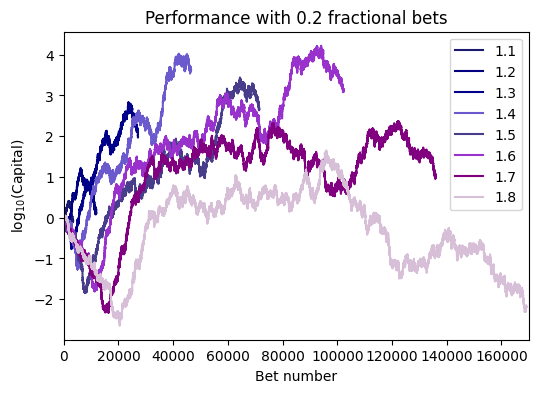

In [18]:
vary_kf(0.2)

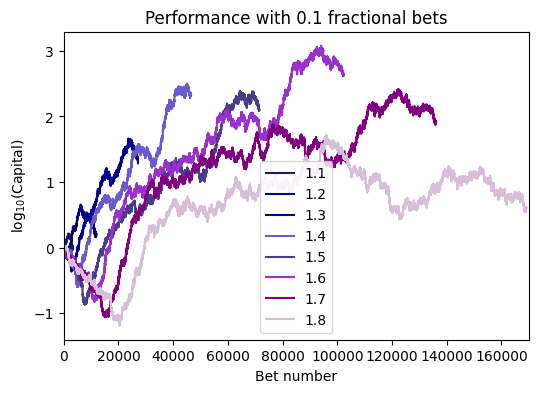

In [19]:
vary_kf(0.1)

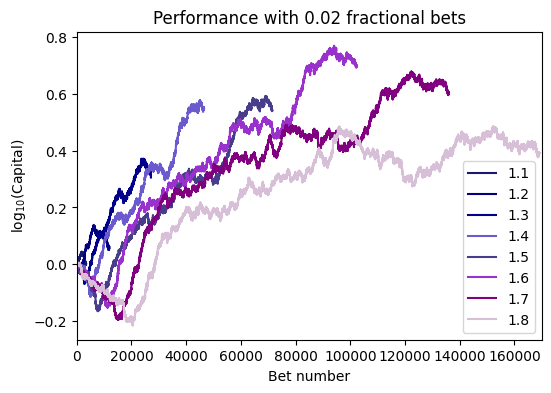

In [20]:
vary_kf(0.02)

Text(0.5, 1.0, 'Performance with 0.01 FIXED fractional bets')

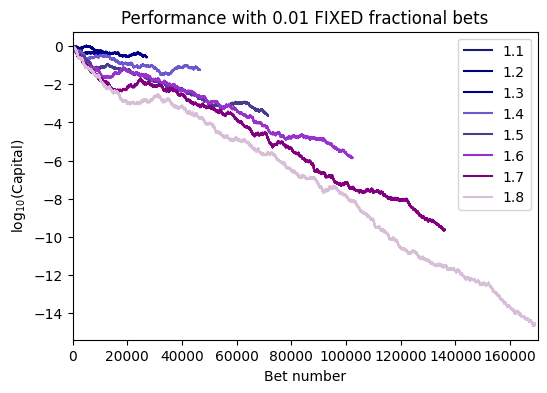

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
colors = ['midnightblue', 'navy', 'darkblue', 'slateblue', 'darkslateblue', 'darkorchid', 'purple', 'thistle']
threshold_list = [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8]
for threshold, color in zip(threshold_list, colors):
    capitals, accepted_odds, consensus_odds = fixed_fraction_strategy(f=0.01, threshold=threshold)
    ax.plot(range(capitals.shape[0]), np.log10(capitals), color=color, label=threshold)
    ax.set_xlabel('Bet number')
    ax.set_ylabel('log$_{10}$(Capital)')
    ax.legend()
ax.set_xlim([0, 170000])
ax.set_title('Performance with 0.01 FIXED fractional bets')